# Libraries importation

In [36]:
import scipy
import pyarrow #to read parquets
import problem #to import the training and test datasets
import time

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.inspection import permutation_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

#import lightgbm as lgb 
#from xgboost import XGBRegressor

# Data importation

In [9]:
data = pd.read_parquet("/Users/Antoine/Desktop/Cours/X-HEC/Cours/Data_with_Python/Bike_project/data/train.parquet")
data_test = pd.read_parquet("/Users/Antoine/Desktop/Cours/X-HEC/Cours/Data_with_Python/Bike_project/data/test.parquet")
data.to_csv('/Users/Antoine/Desktop/Cours/X-HEC/Cours/Data_with_Python/Bike_project/submissions/with_covid/data_test.csv')

# Data preprocessing

## Adding external data

In [14]:
def _merge_external_data(X):
    import math
    __file__ = Path('submissions') /  'starting_kit' /  'estimator.py'
    file_path = Path(__file__).parent / 'external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    features_to_add = ['date', 't', 'ww', 'w1', 'w2', 'n', 'tn12', 'tx12', 'rr1', 'rr3']
    X = pd.merge_asof(X.sort_values('date'), df_ext[features_to_add].sort_values('date'), 
                      on='date', direction='nearest', tolerance=pd.Timedelta('3 hours'))
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    
    #min temp & max temp : polynomial interpolation exept for the first missing data
    X['tn12'] = X['tn12'].interpolate(limit_direction = "both", method = 'polynomial', order=2)
    X['tx12'] = X['tx12'].interpolate(limit_direction = "both", method = 'polynomial', order=2)
    
    #min temp & max temp : linear interpolation for the first missing data
    X['tn12'] = X['tn12'].interpolate(limit_direction = "both")
    X['tx12'] = X['tx12'].interpolate(limit_direction = "both")
    
    #nebulosity & weather : linear interpolation
    X['n'] = X['n'].interpolate(limit_direction = "both")
    X['w1'] = X['w1'].interpolate(limit_direction = "both")
    X['w2'] = X['w2'].interpolate(limit_direction = "both")
    
    #precipitations : negative->0 + linear interpolation
    X.loc[X['rr1'] < 0, 'rr1'] = 0
    X.loc[X['rr3'] < 0, 'rr3'] = 0

    X['rr1'] = X['rr1'].interpolate(limit_direction = "both")
    X['rr3'] = X['rr3'].interpolate(limit_direction = "both")
    
    return X

In [15]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X

In [19]:
def add_weather_data(X):
    X = X.copy()
    
    weather1 = pd.read_csv('/Users/Antoine/Desktop/Cours/X-HEC/Cours/Data_with_Python/Bike_project/data/weather_data_01092020_30042021.csv',
                           parse_dates=['Date time'], 
                           dayfirst=False)
    weather2 = pd.read_csv('/Users/Antoine/Desktop/Cours/X-HEC/Cours/Data_with_Python/Bike_project/data/weather_data_01052021_22102021.csv',
                           parse_dates=['Date time'], 
                           dayfirst=False)

    weather = pd.concat([weather1, weather2]) 
    weather = weather.rename(columns = {'Date time':'date'})
    print(f'Date range :' + str((weather['date'].min(), weather['date'].max())))
    
    interesting_variables = ['Maximum Temperature', 'Minimum Temperature', 'Conditions', 'date']  
    X = pd.merge_asof(X.sort_values('date'), weather[interesting_variables].sort_values('date'), on=['date'])

    return X

In [17]:
def add_holidays(X):
    holidays = pd.read_csv('/Users/Antoine/Desktop/Cours/X-HEC/Cours/Data_with_Python/Bike_project/data/vacances_zones.csv', 
                           parse_dates=['date'])

    interesting_variables = ['date', 'vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c']  
    holidays[['vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c']] = holidays[['vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c']]*1

    X = pd.merge_asof(X.sort_values('date'), holidays[interesting_variables].sort_values('date'), on=['date'])
    
    return X

In [20]:
data1 = _merge_external_data(data)
data2 = _encode_dates(data1)
data3 = add_weather_data(data2)
data4 = add_holidays(data3)

data4.head(2)

Date range :(Timestamp('2020-09-01 00:00:00'), Timestamp('2021-10-22 00:00:00'))


,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,month,day,weekday,hour,Maximum Temperature,Minimum Temperature,Conditions,vacances_zone_a,vacances_zone_b,vacances_zone_c
0,100056332-104056332,Pont de Bercy SO-NE,100056332,Pont de Bercy,0.0,2020-09-01 01:00:00,2019-12-11,"48.83848,2.37587",Y2H19070378,48.83848,...,9,1,1,1,21.4,11.5,Clear,0,0,0
1,100047542-103047542,Face au 48 quai de la marne NE-SO,100047542,Face au 48 quai de la marne,1.0,2020-09-01 01:00:00,2018-11-29,"48.89172,2.38531",Y2H18086318,48.89172,...,9,1,1,1,21.4,11.5,Clear,0,0,0


In [21]:
print(f"Date range : {(data['date'].min(), data['date'].max())}.")

Date range : (Timestamp('2020-09-01 01:00:00'), Timestamp('2021-08-09 23:00:00')).


In [ ]:
# Creating the external data file
data_ext3.to_csv('/Users/Antoine/Desktop/Cours/X-HEC/Cours/Data_with_Python/Bike_project/submissions/with_covid/external_data.csv')

## Define the pipeline

In [33]:
def _add_all_external_data(X):
    #file_path = Path(__file__).parent / 'external_data.csv'
    all_external_data = pd.read_csv('/Users/Antoine/Desktop/Cours/X-HEC/Cours/Data_with_Python/Bike_project/submissions/with_covid/external_data.csv', 
                                    parse_dates=['date'])

    interesting_variables = ['Maximum Temperature', 'Minimum Temperature', 'Temperature',
                             'Precipitation', 'Wind Speed', 'Cloud Cover', 'Conditions', 
                             'vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c', 'day off',
                             't', 'ww', 'w1', 'w2', 'n', 'tn12', 'tx12', 'rr1', 'rr3', 
                             'lockdown1', 'lockdown2', 'lockdown3',
                             'date']
    X = X.copy()
    X['orig_index'] = np.arange(X.shape[0])    
    X = pd.merge_asof(X.sort_values('date'), all_external_data[interesting_variables].sort_values('date'), on='date')
    X = X.sort_values('orig_index')
    del X['orig_index']

    #min temp & max temp : polynomial interpolation exept for the first missing data
    X['tn12'] = X['tn12'].interpolate(limit_direction = "both", method = 'polynomial', order=2)
    X['tx12'] = X['tx12'].interpolate(limit_direction = "both", method = 'polynomial', order=2)
    
    #min temp & max temp : linear interpolation for the first missing data
    X['tn12'] = X['tn12'].interpolate(limit_direction = "both")
    X['tx12'] = X['tx12'].interpolate(limit_direction = "both")
    
    #nebulosity & weather : linear interpolation
    X['n'] = X['n'].interpolate(limit_direction = "both")
    X['w1'] = X['w1'].interpolate(limit_direction = "both")
    X['w2'] = X['w2'].interpolate(limit_direction = "both")
    
    #precipitations : negative->0 + linear interpolation
    X.loc[X['rr1'] < 0, 'rr1'] = 0
    X.loc[X['rr3'] < 0, 'rr3'] = 0

    X['rr1'] = X['rr1'].interpolate(limit_direction = "both")
    X['rr3'] = X['rr3'].interpolate(limit_direction = "both")
    
    X[['vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c']] = X[['vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c']]*1
    
    return X

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    #X.loc[:, 'year_inst'] = X['counter_installation_date'].dt.year
    #X.loc[:, 'month_inst'] = X['counter_installation_date'].dt.month
    
    return X

def get_estimator():
    add_all_external_data = FunctionTransformer(_add_all_external_data)
    date_encoder = FunctionTransformer(_encode_dates)

    categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    categorical_cols = ["counter_id", "Conditions", "counter_installation_date",
                       'day off', 'vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c', 
                       'lockdown1', 'lockdown2', 'lockdown3']
    
    date_cols = ["year", 'month', "weekday", 'hour']

    
    numerical_cols = ['t', 'tn12', 'tx12', 'w1', 'w2', 'n', 'rr1', 'rr3', 
                      'Temperature', 'Maximum Temperature', 'Minimum Temperature',
                      'Precipitation', 'Wind Speed', 'Cloud Cover']

    preprocessor = ColumnTransformer([("cat", categorical_encoder, categorical_cols),
                                      ("num", StandardScaler(), numerical_cols),
                                      ("date", "passthrough", date_cols)])
       
    regressor = HistGradientBoostingRegressor(random_state=0)
    #learning_rate=0.04, max_depth=6
    
    #regressor = XGBRegressor(n_estimators=100, early_stopping_rounds=5)

    pipe = make_pipeline(add_all_external_data, 
                         date_encoder,
                         preprocessor, 
                         regressor)

    return pipe

## Tuning parameters with GridSearch

In [23]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
categorical_cols = ["counter_id", "Conditions", "counter_installation_date",
                   'day off', 'vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c']

date_cols = ["year", 'month', "weekday", 'hour']


numerical_cols = ['t', 'tn12', 'tx12', 'w1', 'w2', 'n', 'rr1', 'rr3']
#'Temperature', 'Maximum Temperature', 'Minimum Temperature','Precipitation', 'Wind Speed', 'Cloud Cover',

preprocessor = ColumnTransformer([("cat", categorical_encoder, categorical_cols),
                                  ("num", StandardScaler(), numerical_cols),
                                  ("date", "passthrough", date_cols),
                                  ("y", "passthrough", ['log_bike_count'])])

grid_data = pd.DataFrame(preprocessor.fit_transform(_encode_dates(_add_all_external_data(data))))

In [24]:
raw_data = _encode_dates(_add_all_external_data(data))

In [25]:
y = raw_data['log_bike_count']
raw_data = raw_data.drop('log_bike_count', axis=1)
raw_data.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'Maximum Temperature',
       'Minimum Temperature', 'Temperature', 'Precipitation', 'Wind Speed',
       'Cloud Cover', 'Conditions', 'vacances_zone_a', 'vacances_zone_b',
       'vacances_zone_c', 'day off', 't', 'ww', 'w1', 'w2', 'n', 'tn12',
       'tx12', 'rr1', 'rr3', 'lockdown1', 'lockdown2', 'lockdown3', 'year',
       'month', 'day', 'weekday', 'hour'],
      dtype='object')

In [29]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [56]:
# GridSearch for XGBRegressor

"""xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
          'objective':['reg:linear'],
          'learning_rate': [.03, 0.05, .07], #so called `eta` value
          'max_depth': [5, 6, 7],
          'min_child_weight': [4],
          'silent': [1],
          'subsample': [0.7],
          'colsample_bytree': [0.7],
          'n_estimators': [100]}

xgb_grid = GridSearchCV(xgb1,
                    parameters,
                    cv = 2,
                    n_jobs = 5,
                    verbose=True)

xgb_grid.fit(pd.DataFrame(preprocessor.fit_transform(raw_data)), y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
"""
print()

In [34]:
pipeline = get_estimator()

In [37]:
t1 = time.time()
cv = TimeSeriesSplit(n_splits=4)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', error_score=np.nan)
t2 = time.time()

print(f'RMSE: {-scores.mean():.3} ± {(-scores).std():.3}/nTime : {t2-t1}')

RMSE: 0.92 ± 0.184/nTime : 80.52760410308838


#### RMSE obtained with different external datas added with HistGradientBoostingRegressor model : 
- {add_external_data, date_encoder, add_weather, preprocessor, regressor} : 1.79  
- {date_encoder, add_weather, preprocessor, regressor} : 1.79  
- {add_external_data, date_encoder, preprocessor, regressor} : 0.93  
 
#### RMSE obtained with different models using the best combination of external datas : 
- HistGradientBoostingRegressor(random_state=0) : RMSE = 0.896 ± 0.226 ; Time = 113.76801896095276               
- XGBRegressor : RMSE = 0.882 ± 0.231 ; Time = 593.0573832988739

## FEATURE IMPORTANCE

In [38]:
merger = pipeline[:2]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipeline[2:]
_ = predictor.fit(X_train_augmented, y_train)

In [39]:
feature_importances = permutation_importance(predictor, 
                                             X_train_augmented[:20000], 
                                             y_train[:20000],
                                             n_repeats=10,
                                             random_state=0)

In [40]:
sorted_idx = feature_importances.importances_mean.argsort()

Using matplotlib backend: MacOSX


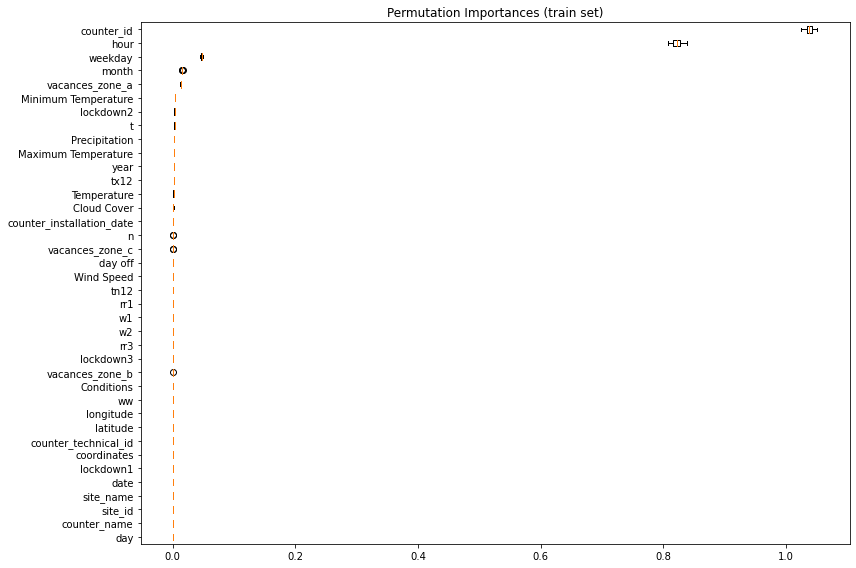

In [53]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()